# ระบบตรวจจับอารมณ์บนใบหน้าระหว่างการขับรถยนต์ด้วย Deep learning
---
## แหล่งอ้างอิ้งของเนื้อหา
- https://www.kaggle.com/code/milan400/human-emotion-detection-by-using-cnn/notebook

# สมาชิกในกลุ่ม
- 6410401043 ณัฐกฤตา เก้าพัฒนสกุล (หาแหล่งอ้างอิง จัดเตรียม dataset เรียบเรียงข้อมูล)
- 6410450974 ธนดล กฤตวีรนันท์ (จัดเตรียม dataset จำแนกข้อมูล ปรับปรุงโมเดล วิเคราะห์ผล)
- 6410450079 กรณวิทย์ พัฒนโชควานิช (เขียนโค้ดหลัก ปรับแต่ง และพัฒนาโมเดล)
---

## ทำการ import os เข้ามาก่อนเพื่อทำการเปิดในส่วนของ GPU
---
### ตรวจได้ว่าเราสามารถนำ GPU มา run ได้ไหม

In [ ]:
import keras, tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.list_physical_devices('GPU')

---
### ถ้ามีให้เอาตัวที่ output index นั้นมาใส่เพื่อใช้งาน GPU

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' # เอา index ที่หาได้จาก gpus มาใส่

---
### แต่ถ้าไม่มี run อันนี้

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

---

## import library ที่ใช้งานเข้ามา

In [2]:
import random,numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras, tensorflow as tf
import os,cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(os.listdir("data"))

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## ทำการ set_seed

In [3]:
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# import image

In [4]:
data_path = 'data'
data_dir_list = os.listdir(data_path)

num_epoch=10

img_data_list=[] # รูปภาพได้ภาพทั้งหมดที่อ่านมาได้
data_count=[] # เก็บจำนวนแต่ละภาพที่จะรับเข้ามา
num_classes = 0 # เก็บว่ามีกี่ class
names = [] # เก็บข้อมูลไว้ตำแหน่งนั้นๆไว้

for dataset in data_dir_list:
    # เราจะได้ชื่อไฟล์ของภาพใน folder นั้นๆ
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    names.append(dataset)
    print ('count of image in folder: {}\n'.format(len(img_list)))
    data_count.append(len(img_list)-1) # เอาไว้ใช้ในตอนทำผลเฉลยออกมา
    num_classes += 1
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        # input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY) # แปลงรูปเป็น grayscale
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
print('data_count: {}\n'.format(data_count))
print('names: {}\nnum_classes: {}'.format(names,num_classes))
img_data.shape

Loaded the images of dataset-angry

count of image in folder: 1000

Loaded the images of dataset-disgust

count of image in folder: 436

Loaded the images of dataset-fear

count of image in folder: 1000

Loaded the images of dataset-happy

count of image in folder: 1000

Loaded the images of dataset-neutral

count of image in folder: 1000

Loaded the images of dataset-sad

count of image in folder: 1000

Loaded the images of dataset-surprise

count of image in folder: 1000

data_count: [999, 435, 999, 999, 999, 999, 999]

names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes: 7


(6436, 48, 48, 3)

# Putting label in data

In [5]:
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

start = 0
stop = 0

for i in range(num_classes):
    stop += data_count[i]
    labels[start:stop] = i
    start = stop + 1
    stop += 1

print('labels: {}'.format(labels))

# labels[0:134]=0 anger
# labels[135:188]=1 contempt
# labels[189:365]=2 disgust
# labels[366:440]=3 fear
# labels[441:647]=4 happy
# labels[648:731]=5 sadness
# labels[732:980]=6 surprise

# names = ['anger','contempt','disgust','fear','happy','sadness','surprise'] # ตามการเรียงไฟล์ของ folder data

def getLabel(id):
    return names[id] # ตามการเรียงไฟล์ของ folder data

labels: [0 0 0 ... 6 6 1]


# แยกข้อมูลที่จะทำการ train และ test

In [6]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# สร้างโครงสร้างของ model

In [7]:
# set_seed(12345)

# input_shape=(48,48,3)

# # let's build a CNN using Keras' Sequential capabilites
# model = Sequential()

# ## 5x5 convolution
# model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


# ## Another 5x5 convolution
# model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# ## Flatten turns
# model.add(Flatten())
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation = 'sigmoid'))

# model.summary()

set_seed(12345)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

# คำนวณ model ที่ได้ทำ

In [8]:
# batch_size = 32

#initiate RMSprop optimizer
# opt = keras.optimizers.RMSprop(learning_rate=0.0005)


# model.compile(loss='categorical_crossentropy',
#               metrics=['accuracy'],
#               optimizer=opt)

# history_1 = model.fit(x_train, y_train,
#                      batch_size=batch_size,
#                      epochs=10,
#                      validation_data=(x_test, y_test),
#                      shuffle=True)

batch_size = 32
num_epoch = 20

#initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0005)


model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=opt)

history_1 = model.fit(x_train, y_train,
                     batch_size=batch_size,
                     epochs=num_epoch,
                     validation_data=(x_test, y_test),
                     shuffle=True)

Epoch 1/20
161/161 [==============================] - 13s 77ms/step - loss: 1.9357 - accuracy: 0.1579 - val_loss: 1.9008 - val_accuracy: 0.1630
Epoch 2/20
161/161 [==============================] - 12s 76ms/step - loss: 1.8279 - accuracy: 0.2531 - val_loss: 1.7663 - val_accuracy: 0.2857
Epoch 3/20
161/161 [==============================] - 12s 77ms/step - loss: 1.7255 - accuracy: 0.3190 - val_loss: 1.6651 - val_accuracy: 0.3719
Epoch 4/20
161/161 [==============================] - 12s 77ms/step - loss: 1.6279 - accuracy: 0.3693 - val_loss: 1.5781 - val_accuracy: 0.3960
Epoch 5/20
161/161 [==============================] - 13s 79ms/step - loss: 1.5359 - accuracy: 0.4163 - val_loss: 1.5086 - val_accuracy: 0.4231
Epoch 6/20
161/161 [==============================] - 13s 81ms/step - loss: 1.4539 - accuracy: 0.4528 - val_loss: 1.5055 - val_accuracy: 0.4239
Epoch 7/20
161/161 [==============================] - 13s 80ms/step - loss: 1.3806 - accuracy: 0.4796 - val_loss: 1.4313 - val_accuracy:

# ทำการ plot graph

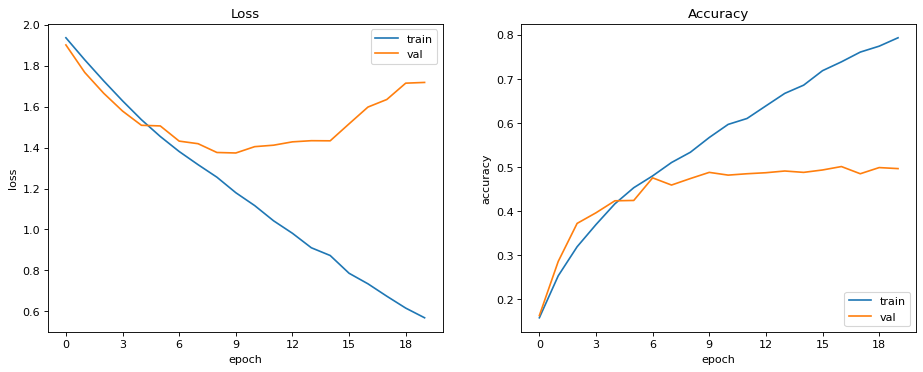

In [9]:
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['loss'])
ax.plot(history_1.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_1.history['accuracy'])
ax.plot(history_1.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

## ประเมิน model ที่เราได้ทำ

In [10]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_test, y_test, verbose=0)))

y_pred = model.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T

Train Loss: 0.267209, Accuracy: 0.934538
 Test Loss: 1.717772, Accuracy: 0.496118


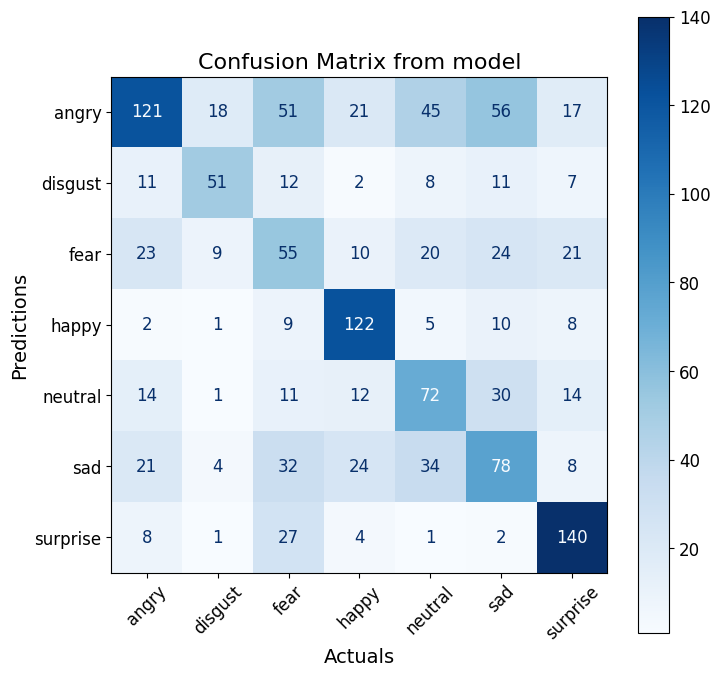

In [11]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title('Confusion Matrix from model', fontsize=16)
plt.show()

# ทดสอบกับรูปภาพที่ได้รับมา
---
## เอาข้อมูลเข้ามาใน test_list ก่อน

In [46]:
'''
list_data_test = []
test_label=[]

for folder in os.listdir('test'):
    test_folder = os.listdir('test/'+folder) # เอารูปที่อยู่ใน folder นั้นออกมา
    for test_img in test_folder:
        input_img=cv2.imread('test/'+ folder + '/' + test_img)
        input_img_resize=cv2.resize(input_img,(48,48))
        list_data_test.append(input_img_resize)
        test_label.append(folder)
    
img_test = np.array(list_data_test)
img_test = img_test.astype('float32')
img_test = img_test/255
'''

## ทำการ predict รูปภาพทั้งหมด

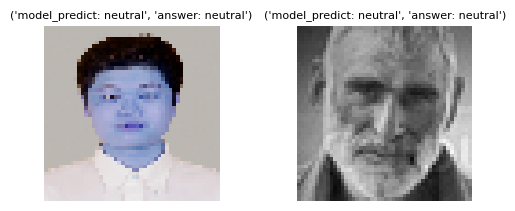

In [68]:
'''
predict = model.predict(img_test, verbose=0)
predict = np.argmax(predict,axis=1)

fig = plt.figure(figsize=(6, 5))

for i in range(len(test_label)):
    fig.add_subplot(len(test_label), 2, i+1)
    
    plt.imshow(img_test[i])
    plt.axis('off')
    text = 'model_predict: ' + getLabel(predict[i]), 'answer: ' + test_label[i]
    plt.title(text, fontsize=8)
'''

---
## ทำการ detect vedio ที่ได้รับมา

In [12]:
# prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

# start the webcam feed
cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
        
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        # roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(frame, (48, 48)), -1), 0)
        
        cropped_img = np.array(cropped_img)
        cropped_img = cropped_img.astype('float32')
        cropped_img = cropped_img/255
        
        prediction = model.predict(cropped_img)
        maxindex = np.argmax(prediction)
        print(maxindex)
        cv2.putText(frame, getLabel(maxindex), (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 13ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 13ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 13ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 13ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 13ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 13ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [=======================

1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 14ms/step
5
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
3
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 15ms/step
3
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 15ms/step
3
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 17ms/step
3
1/1 [==============================] - 0s 14ms/step
3
1/1 [==============================] - 0s 15ms/step
3
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
3
1/1 [=======================

1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 16ms/step
5
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
5
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [=======================

1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 15ms/step
2
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 15ms/step
5
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 14ms/step
2
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [=======================